In [1]:
%load_ext autoreload
%autoreload 2 
# !apt-get install -y xvfb
import time
import torch
import scipy
import scipy.sparse
from collections import Counter
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader, ImbalancedSampler
from torch_geometric.data import Dataset
# https://www.youtube.com/watch?v=QLIkOtKS4os --> creating custom dataset in pytorch geometric
from torch.utils.data import Dataset, random_split
import torch_geometric
from torch_geometric.data import Data, InMemoryDataset
import torch_geometric
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GlobalAttention, SAGEConv

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.utils import to_networkx, from_networkx
from sklearn.model_selection import StratifiedKFold
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import pickle
import seaborn as sn
import random
import os
from typing import Optional

from torch_scatter import scatter_add

from torch_geometric.utils import softmax

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

from graph_utils import set_device_and_seed, set_seed, show, visualize_graph, visualize_embedding, _count_parameters, visualise_airway_tree_matplotlib
from graph_datasets import CustomDataset
from graph_models import CustomGlobalAttention, GAT
from graph_training import train_model, test_model, _vis_graph_example, train_test_split

In [3]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus
!nvidia-smi

Fri Jul 15 12:08:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:05:00.0 Off |                  N/A |
| 65%   85C    P2   229W / 280W |  18081MiB / 24217MiB |     94%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:09:00.0 Off |                  N/A |
| 41%   

### Load Data


In [4]:
orig_df = pd.read_csv(os.path.abspath('/home/sneha/toy_normalised_1407.csv'))
orig_df.describe()

label_df = pd.read_csv(os.path.abspath('/home/sneha/toy_labels_1407.csv'))
label_df

,idno,startbpid,endbpid,graph_label,node_label
0,3010007,-1.0,1.0,0,0
1,3010007,1.0,3.0,0,0
2,3010007,1.0,2.0,0,0
3,3010007,2.0,4.0,0,0
4,3010007,2.0,5.0,0,0
...,...,...,...,...,...
120971,8024979,48.0,89.0,0,0
120972,8024979,64.0,111.0,0,0
120973,8024979,64.0,110.0,0,0
120974,8024979,89.0,135.0,0,0


In [ ]:
# delete a lobe
# orig_df = orig_df.loc[((orig_df.binaryLL_1 == 1) & (orig_df.lobe != 2)) | (orig_df.binaryLL_1 == 0)]
# test.loc[test.binaryLL_1 == 1].groupby('lobe').agg('count')

In [ ]:
# label_df = orig_df[['idno', 'binaryLL_1']].drop_duplicates()
# label_df

### Train test split mask

In [5]:
label_col_name = 'node_label'

In [6]:
train_ids, test_ids = train_test_split(label_df, n_splits_test = 5, label_col_name= label_col_name, seed=0)

pilot_df_train = orig_df.loc[orig_df.idno.isin(train_ids)]
pilot_df_test = orig_df.loc[orig_df.idno.isin(test_ids)]
binary_label_df_train = label_df.loc[label_df.idno.isin(train_ids)]
binary_label_df_test = label_df.loc[label_df.idno.isin(test_ids)]
print("Overall Label frequency distribution", [(x, binary_label_df_test[label_col_name].tolist().count(x)) for x in set(binary_label_df_test[label_col_name].tolist())])


# SAVE PILOT DF for training
pilot_df_train.to_csv('/home/sneha/toy_lobe_cleaned_normalised_w_labels_train.csv')
binary_label_df_train.to_csv('/home/sneha/toy_lobe_binary_labels_train.csv')
pilot_df_test.to_csv('/home/sneha/toy_lobe_cleaned_normalised_w_labels_test.csv')
binary_label_df_test.to_csv('/home/sneha/toy_lobe_binary_labels_test.csv')

Overall Label frequency distribution [(0, 103792), (1, 17184)]
Getting train test split stratified on the 120976 labels
Overall Label frequency distribution [(0, 103792), (1, 17184)]


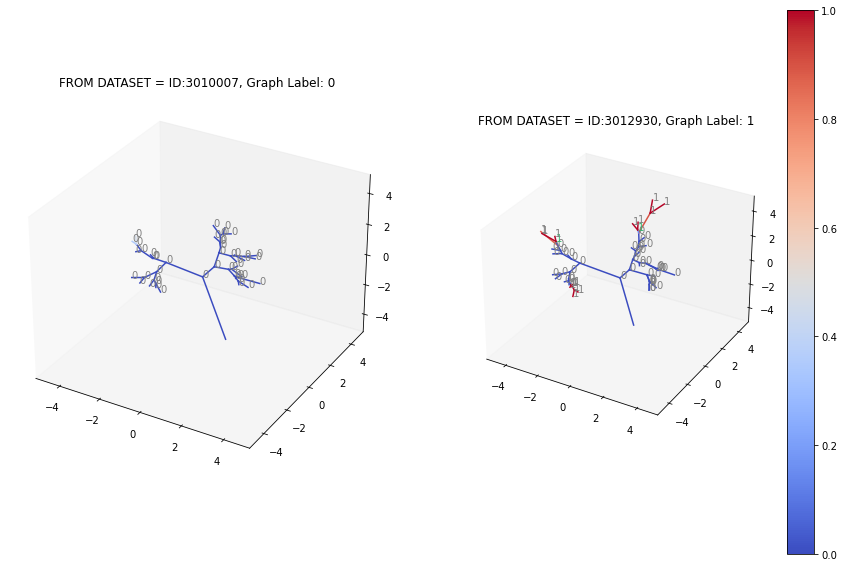

In [183]:

# def _vis_graph_example_2(dataloader,model, index, pilot_df_w_labels, device,visualise_g = False, save_path = None):
#     data = dataloader.dataset[index]
#     print(data)
#     label = data.y
#     g = to_networkx(data)
#     # get relabelmap
#     idno, relabel = dataloader.dataset.node_map[index]
#     # map to original df
#     vis_graph  =pilot_df_w_labels.loc[pilot_df_w_labels.idno==idno]
#     print(f"This graph is for id: {idno}")
#     display(vis_graph.head())
#     # get the relabelling to match the pytorch graph 
#     vis_graph['start_node'] = vis_graph.startbpid.apply(lambda x:relabel[x])
#     vis_graph['end_node'] = vis_graph.endbpid.apply(lambda x:relabel[x])
# #     display(vis_graph[['startbpid', 'endbpid']+node_features + ['parent_loc_x_norm','parent_loc_y_norm']])
# #     print(data.x)
#     print("Getting model preds per node (node model needs to be a per node one)")
#     model.eval()
#     x, weight = model(data.to(device))
#     print("weight", len(weight[0]))
#     x = x.cpu().detach().numpy() # take off cuda
    
#     weight = weight[0].cpu().detach().numpy() # take first item take off cuda
    
# #     print("x", x.shape[0], 'weight', weight.shape[0], 'label', label.shape[0])
    
#     if model.agg == 'none':
# #         print('useing node preds')
#         # per node rather than per graph
#         preds = x.copy().squeeze()
#     else:
#         # per graph output - use per node (weights )for color
# #         print("using weights")
#         preds = weight.copy().squeeze()
# #     print("preds shape", preds.shape)
    
    
#     # drawing graph in networkx & matplotlib
#     cmap = mpl.colormaps['spring'].reversed()
#     vmin, vmax = min(weight), max(weight)
#     norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
#     sm.set_array([])
#     cmap_nodes = [cmap(norm(preds[node])) for node in g.nodes()]
#     edge_labels = {edge:vis_graph.loc[vis_graph.end_node == edge[1]]['anatomicalname'].item() for edge in g.edges()}
#     pos = nx.planar_layout(g, scale=1, center=(0,0), dim=2)
    
    
#     if visualise_g:
#         f, ax = plt.subplots(figsize=(10,10))
#         nx.draw(g,pos=pos, with_labels=False,node_color=cmap_nodes, ax=ax)
#         nx.draw_networkx_edge_labels(g, pos,
#                                   edge_labels,
#                                      font_color='k',
#                                      font_size='10',
#                                   label_pos=0.5,

#                                     )
        
#         cbar = plt.colorbar(sm)

#         plt.title(f'TRAINING GRAPH: {idno}, ANOMALY LABEL: {label.item()}')
#         plt.show()


    
#     fig=plt.figure(figsize=(10,10))
#     ax = fig.add_subplot(projection='3d')
#     for i in range(len(vis_graph)):
#         row = vis_graph.iloc[i]
#         ax.plot([row.parent_loc_x,row.x], [row.parent_loc_y,row.y], [row.parent_loc_z, row.z], linestyle='-',linewidth=1, color= cmap(norm(preds[row.end_node])), label=row.end_node)
#         ax.scatter(row.x, row.y, row.z, marker='o',color= cmap(norm(preds[row.end_node])))
#     ax.grid(False)
#     ax.set_facecolor(color=(1,1,1))
#     cbar = plt.colorbar(sm)
#     plt.title(f'TRAINING GRAPH: {idno}, ANOMALY LABEL: {label.item()}')
#     if save_path is not None:
#         plt.savefig(save_path)
#     plt.show()
    
    
def vis_node_preds(my_data_train, indices, model, device, save_path=None):
    # choose random index from each class
    fig=plt.figure(figsize=(15,10))
    for i in range(len(indices)):
        index = indices[i]
        # visualise from dataset
        cmap = mpl.colormaps['coolwarm']
        vmin, vmax = 0,1
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        graph = my_data_train[index]
        locs = graph.x[:, :3]
        labels = graph.y.numpy().astype(int)
#         print('sum',labels.sum())
        edges = graph.edge_index.numpy()
        edges = list(zip(edges[0,:], edges[1,:]))
        model = model.eval()
        out, _ = model(graph.to(device))
        # out is the node probabilities (already has sigmoid applied double check if changing model)
#         print('shape', out.shape)
        out= out.squeeze().cpu().detach().numpy()
        pred = out > 0.5
        pred = pred.astype(int)
        # get FP, TN, TP, FN indices
        TP = []
        FP = []
        TN=[]
        FN=[]
#         print(labels.shape, pred.shape)
        for j in range(len(out)): 
            if labels[j]==pred[j]==1:
                TP.append(j)
            if pred[j]==1 and labels[j]!=pred[j]:
                FP.append(j)
            if labels[j]==pred[j]==0:
                TN.append(j)
            if pred[j]==0 and labels[j]!=pred[j]:
                FN.append(j)
#         print(TN, FN)    
        colors = np.zeros_like(pred, dtype='long')
        colors[TP] = 0
        colors[FP] = 1
        colors[TN] = 2
        colors[FN] = 3
        color_dict = {
            0: 'gray',
            1:'red',
            2:'gray',
            3:'mediumseagreen'
        }
        colors_rgb = [color_dict[color] for color in colors]
        # draw each edges
#         fig=plt.figure(figsize=(10,10))
        ax = fig.add_subplot(1, 2, i+1, projection='3d')
#         ax = fig.add_subplot(projection='3d') 
        ax.set_xlim(-5,5)
        ax.set_ylim(-5,5)
        ax.set_zlim(-5,5)
        for startidx, endidx in edges:
            start_loc, end_loc = locs[startidx], locs[endidx]
            ax.plot([start_loc[0], end_loc[0]],[start_loc[1], end_loc[1]],[start_loc[2], end_loc[2]], color=cmap(norm(float(out[endidx]))))
#             ax.text(int(sum([start_loc[0], end_loc[0]])/2), int(sum([start_loc[1], end_loc[1]])/2),int(sum([start_loc[2], end_loc[2]])/2), str(int(labels[endidx])), color=cmap(norm(int(labels[endidx]))))
            ax.text(end_loc[0], end_loc[1], end_loc[2], str(int(labels[endidx])),color=colors_rgb[endidx])
        
        
        plt.title(f'FROM DATASET = ID:{my_data_train.node_map[index][0]}, Graph Label: {max(labels)}')
        ax.grid(False)
    cbar = plt.colorbar(sm)
    if save_path is not None:
        plt.savefig(os.path.abspath(save_path))
    plt.show()

vis_node_preds(my_data_train,indices=[0,100],model=model, device=device)

In [7]:


class CustomDatasetNode(torch_geometric.data.Dataset):
    def __init__(self,
                 root,
                 filename_data,
                 filename_labels,
                 test=False,
                 transform=None,
                 pre_transform=None,
                 label_col_name = 'binaryLL_1',
                 node_level = True,
                args = {'node_feature_names': [], 'edge_feature_names': []}):
        '''
        For NODE LEVEL CLASSIFICATION
        root = where dataset should be stored, folder is split into raw_dir and processed_dir
        filename_data = contains X features for nodes + edges (csv)
        filename_labels= contains Y labels for graphs (csv)
        
        
        '''

            
            
        self.test = False
        self.filename_data = os.path.abspath(filename_data)
        self.filename_labels = os.path.abspath(filename_labels)
        self.node_map = {}
        self.node_level = node_level
        self.y = None
        #         super(CustomDataset, self).__init__(root, transform, pre_transform)
        if len(args['node_feature_names']) > 0:
            self.node_feature_names = args['node_feature_names']
        else:
            self.node_feature_names = None
        
        if len(args['edge_feature_names']) > 0:
            self.edge_feature_names = args['edge_feature_names']
        else:
            self.edge_feature_names = None
        print(f"Using Node features: {self.node_feature_names}, Edge features: {self.edge_feature_names}")
        self.label_col = label_col_name
        print(f"Getting labels from: {self.label_col}")
        super(CustomDatasetNode, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        return self.filename_data
    
    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped: NOTE NOT SURE WHAT THIS IS"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
    
    def _download(self):
        pass
    
    def process(self):
        self.data = pd.read_csv(os.path.abspath(self.raw_paths[0]))
        label_df = self._process_labels()
        graph_ids = self.data.idno.unique()
        
        for i, idno in tqdm(list(enumerate(graph_ids))):
            # iterate through each patricipant (resetindex is important for node relabelling)
            df = self.data.loc[self.data.idno == idno].copy().reset_index()
            # build a graph out of the df with node features, edge_features and edge_adjacency
            x = self._get_node_features(df)
            edge_adjacency = self._get_edge_adjacency(df,index=i)
            edge_features = self._get_edge_features(df)
            y = self._get_label(idno, label_df, x)
            data = Data(x=x,
                        edge_index=edge_adjacency,
                        edge_attr = edge_features,
                        y = y
                       )
            if self.test:
                torch.save(data, 
                            os.path.join(self.processed_dir, 
                                         f'data_test_{i}.pt'))
            else:
                 torch.save(data, 
                            os.path.join(self.processed_dir, 
                                         f'data_{i}.pt'))
    
    
    def _process_labels(self):
        '''
        Reads label df - checks its binary 0,1 labels (REQUIRES COLUMN self.label_col) if not returns an error 
        Keeps only rows that match idnos in self.data_df which is processed first
        measures class proportions and saves to self.class_proportions
        returns a df which has a label per idno with label in col called 'y'
        '''
        label_df = pd.read_csv(os.path.abspath(self.filename_labels))
        # binarise 
        assert self.label_col in label_df.columns, f"The column {self.label_col} cannot be found"
        # drop unnecessary cols
        
        # drop rows not matching to data ids
        data_df =  pd.read_csv(os.path.abspath(self.filename_data))
        label_df_small = label_df.loc[label_df.idno.isin(data_df.idno.unique())]
        self.y = label_df_small
        print("# Graphs", len(label_df_small), "Label Frequency", Counter(label_df_small[self.label_col].to_list()))
        self.class_proportions = {k:v/len(label_df_small) for k,v in Counter(label_df_small[self.label_col].to_list()).items()}
        print(f"Class proportions: {self.class_proportions}")
        return label_df_small
    
    def _get_edge_adjacency(self,df, index):
        '''
        NOTE pytorch requires nodes to start from 0 and go up in integers so need to remap start and end bpids from df
        Turns endbpid 1 > 1, if the next one in the df is endbpid=6 it becomes 2 etc so that the endbpids are in order from 1 to max (index+1)
        Adds trachea (node 0)
        applyys relabelling to start and endbpid based on the dict 
        returns torch tensor in COO format which is a parallel list [[source_node_list], [corresponding_end_node_list]]
        in this format, at list[0][2] and list[1][2] will be source-end node of the second edge in the list
        '''
        # reindex start / endbpids
        
        relabel_map = {v:k+1 for k,v in df.endbpid.to_dict().items()}
        # add trachea map (node 0)
        relabel_map[-1] = 0
        # save mapping
        self.node_map[index] = (df.idno.unique().item(), relabel_map)
        # apply relabelling to source and end nodes
        source_nodes = df.startbpid.apply(lambda x: relabel_map[x]).to_list()
        end_nodes = df.endbpid.apply(lambda x: relabel_map[x]).to_list()
        # return in COO format
        return torch.tensor([source_nodes, end_nodes], dtype=torch.long)

    def _get_node_features(self,df):
        '''
        DF already contains normalised features
        Feature names in node_features
        Format to return is a tensor of shape num_nodes x node_feature_dim with dtype float 
        assumes ordered in ascending order with nodes 0 and up in integers (so node = index / row num)
            node_features = ['x_norm', 'y_norm', 'z_norm', 'dircosx_norm',
       'dircosy_norm', 'dircosz_norm','lobe_norm',
       'sublobe_norm','angle_norm', 'weibel_generation_norm','dist_nn_in_lobe_norm', 'num_desc_norm','max_path_length_norm']

        '''
        # nodes and features (pos, direction,lobe + sublobe categorical, angle to parent, weibel gen, dist to nearest neighbor in lobe, max path length to leaf, num descendents of node)
        node_features = self.node_feature_names

        # adding trachea info to top of list
        trachea_dict = dict.fromkeys(node_features, 0)
        for i in ['nx', 'ny', 'nz']:
            trachea_dict[i] = df.loc[df.endbpid==1][str('parent_loc_'+i)].item()
        
        # currently usnig as features 
        list_of_nodes = df[node_features].to_dict(orient='records')
        # add trachea to nodes
        list_of_lists_nodes =[list(trachea_dict.values())]+ [list(node_feature.values()) for node_feature in list_of_nodes]
        x = torch.tensor(list_of_lists_nodes, dtype=torch.float)
#         print("Shape node features", x.shape)
        return x

    def _get_edge_features(self,df):
        '''
        get matrix of shape [# edges, edge feature size] with type float
        '''
        if self.edge_feature_names is not None:
            edge_feature_names = self.edge_feature_names
        else:
            edge_feature_names = ['centerlinelength_norm','avginnerarea_norm']
            
        edge_norm = df[edge_feature_names].values
        return torch.tensor(edge_norm, dtype=torch.float)

    def _get_label(self, idno, label_df,node_features):
        '''
        for the selected idno, returns value in self.label_col as an integer
        '''
        # Assume trachea node is always non anomalous (0)
        if self.node_level:
            labels = label_df.loc[label_df.idno==idno,
                 self.label_col].values
            
            num_nodes = node_features.shape[0]
            if num_nodes -1 == labels.shape[0]:
#                 print('adding in label for node -1 = 0 in pytorch method')
                labels = [0] + list(labels)
            
#                 print('Num nodes, num labels', num_nodes, len(labels))
            
            return torch.tensor(labels, dtype=torch.int64)
        else:
            # return single graph label
            labels = label_df.loc[label_df.idno==idno,
                 self.label_col].unique()
#             print('num labels per graph', labels.shape[0])
        
            return torch.tensor(labels, dtype=torch.int64)
    
    def len(self):
        return int(self.data.idno.nunique())
    
    def get(self, idx):
        '''
        Equivalent to __getitem__ in pytorch
        '''
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))   
        return data
            

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [ ]:
def dice_loss(input, target):
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

def bce_loss(input, target):
    return F.binary_cross_entropy(input.squeeze(),target.float())

def weighted_bce_loss(input, target, weights):
    return F.binary_cross_entropy(input.squeeze(),target.float(), weight=weights.float())


loss_fn = nn.BCELoss()
# make training function
def train_model(model, 
                optimizer,
                train_loader, 
                device,
                num_epochs, 
                loss_fn,
                count_epochs=0,
                verbose=True, 
                scheduler=None, 
                accum_iter=1, 
                class_weight=None,
               node_level=True,
               ):
    
    plotting_dict_train = {"loss":[], "accuracy": []}
    noisy_label=False
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        denominator_loss = 0
        denominator_acc=0
        for batch_idx, data in list(enumerate(train_loader)):
            data = data.to(device)
            batch_size = data.num_graphs
            batch_vector = data.batch
            
            # reset gradients
            if batch_idx % accum_iter ==0:
                optimizer.zero_grad()

            # conduct a forward pass
            out, weight = model(data)
#             print("out", out.shape, out)
            y = data.y.float()
#               # Noisy vs per graph labelling depending on model type
#             if (out.squeeze()).shape != data.y.shape:
#                 noisy_label = True
#                 y = torch.take(data.y.float(), batch_vector) # repeat label shape
# #                 print('Noisy labelling', y.shape)
#                 # denominator for accuracy etc. is y.shape from here (to average out per node accuracy)
#             else:
#                 y = data.y.float()
#                 print('Not changing label format', y.shape, 'balance', y.sum()/len(y))
                # denominatro here is y.shape (per graph to avg out graph accuracy)
#             print(y.shape[0])
            denominator_acc +=y.shape[0] # will either be length batch size for graph level or length of # nodes
            denominator_loss+=y.shape[0]
            # calculate loss and metrics
            pred = out > 0.5
            pred = pred.long()
#             print(pred.unique())
            correct += pred.eq(y.view_as(pred)).sum().item()
#             print('shapes', y.shape, out.shape)
            
            if class_weight is not None:
                weights = torch.take(class_weight.to(device), y.long()) # class_weight has weight for 0 in posnt 0 and 1 in 1
#                 print("weights", weights, y, sep='\n')
#                 loss = F.binary_cross_entropy(out.squeeze(),y.float(), weight=weights.float())
                loss = loss_fn(out.squeeze(),y.float(), weight=weights.float())
            else:
#                 loss = F.binary_cross_entropy(out.squeeze(),y)
                loss = loss_fn(out.squeeze(),y.float())
                
#             print("loss", loss)
            train_loss += loss.item()

            # backward pass, normalising for gradient accumulation
            loss = loss / accum_iter
            loss.backward()
            
            # step
            if (batch_idx % accum_iter == 0) or (batch_idx + 1 == len(train_loader)):
                optimizer.step()

                
            if verbose:
                print('Epoch: {}, Batch: {}, Loss: {:.2f}'.format(epoch+count_epochs, batch_idx, loss.item()))
        # calculate loss and error for epoch
        train_loss /= denominator_loss # loss is already mean over the nodes so just divide by num graphs in batch
        accuracy = correct / denominator_acc # if doing noisy labelling need to do length of vector
        plotting_dict_train["loss"].append(train_loss)
        plotting_dict_train["accuracy"].append(accuracy)
        
        # step at the end of each epoch
        if scheduler is not None:
            scheduler.step()
            
            if scheduler is not None:
                last_lr = scheduler.get_last_lr()[0]
            
        print('Epoch: {}, Train Loss: {:.5f}, Train Accuracy: {:.5f}'.format(epoch+count_epochs, train_loss, accuracy))
        
    return plotting_dict_train



def test_model(model, test_loader, device, count_epochs = 0, threshold=0.5):
    print(f"Getting F1 score, Accuracy and Confusion matrix on the Test Set at epoch {count_epochs}")
    predictions = []
    y = []
    model.eval()
    with torch.no_grad():
        for batch_idx, data in list(enumerate(test_loader)):
            data = data.to(device)
            label = data.y
            batch_vector = data.batch
            batch_size = data.num_graphs
            outputs, _ = model(data)
            pred = outputs > threshold
            pred = pred.long()
            label_f = label.float()
            predictions.append(pred)
            y.append(label_f)

    predictions_tensor = torch.cat(predictions).cpu().numpy().squeeze()
    labels_tensor = torch.cat(y).cpu().numpy().squeeze()
    print("preds, labels", predictions_tensor.shape, labels_tensor.shape)
    cm = confusion_matrix(labels_tensor, predictions_tensor)
    f1 = f1_score(labels_tensor, predictions_tensor, average='binary')
    accuracy = accuracy_score(labels_tensor, predictions_tensor)
    print("F1 score for positive class (1): {:.2f}".format(f1))
    print("Accuracy: {:.2f}".format(accuracy))
    data = {'y_Actual':  labels_tensor.copy(),
        'y_Predicted': predictions_tensor.copy()
        }
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    
    confusion_matrix_pd = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    plt.figure()
    sn.heatmap(confusion_matrix_pd, annot=True,fmt = '.0f', square=1, linewidth=1.)
    plt.title("Confusion Matrix")
    plt.savefig(f"confusion_matrix_{count_epochs}.jpg")
    plt.show()
    
    return cm, f1, accuracy


In [ ]:
class MyGCN(torch.nn.Module):
    '''
    Simple GNN for graph preds
    hidden_channels = [8,8,8] for now
    
    '''
    def __init__(self, in_channels, hidden_channels = 8, out_channels= 1, dropout=0.2, graph_level=False):
        super(MyGCN, self).__init__()
        self.dropout=dropout
        self.graph_level = graph_level
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels,hidden_channels)
        self.conv3 = GCNConv(hidden_channels,hidden_channels)
        self.lin =  nn.Sequential(
                                        nn.Linear(hidden_channels, out_channels),
                                        nn.Sigmoid()
                                    )
        

    def forward(self, data):
        x, edge_index,  batch = data.x, data.edge_index, data.batch
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        
        # 2. Readout layer
        if self.graph_level:
            x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        # 3. Apply a final classifier
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin(x)
        
        return x, None
    
    


# class GlobalAttentionNet(torch.nn.Module):
#     '''
#     Does per node predictions
    
    
#     '''
#     def __init__(self, in_channels, out_channels, num_layers, hidden):
        
#         super().__init__()
#         self.conv1 = SAGEConv(in_channels, hidden)
#         self.convs = torch.nn.ModuleList()
#         for i in range(num_layers - 1):
#             self.convs.append(SAGEConv(hidden, hidden))
#         self.att = GlobalAttention(Linear(hidden, 1))
#         self.lin1 = Linear(hidden, hidden)
#         self.lin2 = Linear(hidden, out_channels)

#     def forward(self, data):
#         x, edge_index, batch = data.x, data.edge_index, data.batch
#         x = F.relu(self.conv1(x, edge_index))
#         for conv in self.convs:
#             x = F.relu(conv(x, edge_index))
#         x = self.att(x, batch)
#         x = F.relu(self.lin1(x))
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.lin2(x)
#         return F.log_softmax(x, dim=-1)

#     def __repr__(self):
#         return self.__class__.__name__

testmodel = MyGCN(in_channels=13, hidden_channels=8, out_channels=1)
testmodel

### Training Pipeline

In [185]:
run_id = 6
try:
    os.makedirs(f'/home/sneha/airway_exploration/graph_networks/run_{run_id}/')
except:
    pass

verbose= True
# device = set_device_and_seed(GPU=True, gpu_name='cuda:0')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

batch_size = 64
num_epochs = 10

test_every = 1
weighted_loss = False
model_agg = 'mean'
dropout = 0.2
hidden_dim1 = 8
hidden_dim2 = 8
lr=0.01
weight_decay=5e-4
loss_fn = dice_loss

Device cuda


In [16]:
label_col_name='node_label'

#  removed from features for toy example, added edge features to node ones too just in case
node_features = ['nx', 'ny', 'nz', 'dircosx_norm',
               'dircosy_norm', 'dircosz_norm','angle_norm', 'weibel_generation_norm','dist_nn_in_lobe_norm',
                 'num_desc_norm','max_path_length_norm','centerlinelength_norm','avginnerarea_norm',
                'lobe_norm', 'num_children']
edge_feature_names = ['centerlinelength_norm','avginnerarea_norm']

args = {'node_feature_names': node_features, 'edge_feature_names':edge_feature_names}
# DATASETS


my_data_train  = CustomDatasetNode('data_train_toy/',
                               '/home/sneha/toy_lobe_cleaned_normalised_w_labels_train.csv',
                               '/home/sneha/toy_lobe_binary_labels_train.csv',
                               args = args,
                               label_col_name=label_col_name,
                                node_level=True
                              )

my_data_test  = CustomDatasetNode('data_test_toy/',
                               '/home/sneha/toy_lobe_cleaned_normalised_w_labels_test.csv',
                               '/home/sneha/toy_lobe_binary_labels_test.csv',
                               args = args,
                               label_col_name=label_col_name,
                                node_level=True
                              )

Using Node features: ['nx', 'ny', 'nz', 'dircosx_norm', 'dircosy_norm', 'dircosz_norm', 'angle_norm', 'weibel_generation_norm', 'dist_nn_in_lobe_norm', 'num_desc_norm', 'max_path_length_norm', 'centerlinelength_norm', 'avginnerarea_norm', 'lobe_norm', 'num_children'], Edge features: ['centerlinelength_norm', 'avginnerarea_norm']
Getting labels from: node_label


Processing...


# Graphs 120976 Label Frequency Counter({0: 103792, 1: 17184})
Class proportions: {0: 0.857955296918397, 1: 0.14204470308160297}


100%|██████████████████████████████████████████████████████████████████████████████| 2093/2093 [00:12<00:00, 171.87it/s]
Done!


Using Node features: ['nx', 'ny', 'nz', 'dircosx_norm', 'dircosy_norm', 'dircosz_norm', 'angle_norm', 'weibel_generation_norm', 'dist_nn_in_lobe_norm', 'num_desc_norm', 'max_path_length_norm', 'centerlinelength_norm', 'avginnerarea_norm', 'lobe_norm', 'num_children'], Edge features: ['centerlinelength_norm', 'avginnerarea_norm']
Getting labels from: node_label


Processing...


# Graphs 120976 Label Frequency Counter({0: 103792, 1: 17184})
Class proportions: {0: 0.857955296918397, 1: 0.14204470308160297}


100%|██████████████████████████████████████████████████████████████████████████████| 2093/2093 [00:12<00:00, 167.28it/s]
Done!


In [184]:
# # visualise from DATASET
# cmap = mpl.colormaps['spring']
# vmin, vmax = 0,1
# norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# index=100
# graph = my_data_train[index]
# locs = graph.x[:, :3]
# print(locs.shape)
# labels = graph.y
# edges = graph.edge_index.numpy()
# edges = list(zip(edges[0,:], edges[1,:]))
# # draw each edges
# fig=plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')
# for startidx, endidx in edges:
#     start_loc, end_loc = locs[startidx], locs[endidx]
#     ax.plot([start_loc[0], end_loc[0]],[start_loc[1], end_loc[1]],[start_loc[2], end_loc[2]], color=cmap(norm(int(labels[endidx]))))
# plt.title(f'FROM DATASET = ID:{my_data_train.node_map[index][0]}, Graph Label: {max(labels)}')
# plt.show()

# # Now repeat from the original data to double check
# idno = my_data_train.node_map[index][0]
# test_df = orig_df.loc[orig_df.idno==idno][['startbpid', 
#                                            'endbpid',
#                                            'nx', 'ny', 'nz', 
#                                            'parent_loc_nx', 'parent_loc_ny','parent_loc_nz' ]].reset_index()
# labels = label_df.loc[label_df.idno==idno].node_label.to_list()

# # draw each edges
# fig=plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')
# for i in range(len(test_df)):
#     row = test_df.iloc[i]
#     ax.plot([row.parent_loc_nx, row.nx],[row.parent_loc_ny, row.ny],[row.parent_loc_nz, row.nz],
#             color=cmap(norm(int(labels[i]))))
# plt.title(f'FROM DF = ID:{my_data_train.node_map[index][0]}, Graph Label: {max(labels)}')
# plt.show()

In [ ]:
# label_col_name='graph_label'

# #  removed from features for toy example, added edge features to node ones too just in case
# node_features = ['x_norm', 'y_norm', 'z_norm', 'dircosx_norm',
#                'dircosy_norm', 'dircosz_norm','angle_norm', 'weibel_generation_norm','dist_nn_in_lobe_norm',
#                  'num_desc_norm','max_path_length_norm','centerlinelength_norm','avginnerarea_norm',
#                 'lobe_norm','sublobe_norm']
# edge_feature_names = ['centerlinelength_norm','avginnerarea_norm']

# args = {'node_feature_names': node_features, 'edge_feature_names':edge_feature_names}
# # DATASETS
# my_data_train  = CustomDataset('data_train_toy/',
#                                '/home/sneha/toy_lobe_cleaned_normalised_w_labels_train.csv',
#                                "/home/sneha/toy_lobe_binary_labels_train.csv",
#                                args = args,
#                                label_col_name=label_col_name
#                               )

# my_data_test  = CustomDataset('data_test_toy/', 
#                               '/home/sneha/toy_lobe_cleaned_normalised_w_labels_test.csv',
#                               "/home/sneha/toy_lobe_binary_labels_test.csv",
#                               args = args,
#                               label_col_name=label_col_name
#                              )



In [186]:
# print(my_data_train.y)

# sampler_train = ImbalancedSampler(my_data_train, num_samples=-1)

# from torch_geometric.loader import NeighborLoader, ImbalancedSampler

# train_loader = NeighborLoader(my_data_train,num_neighbors= -1, sampler=sampler_train, batch_size=batch_size, shuffle=False)
# # loader = NeighborLoader(data, input_nodes=data.train_mask,
# #                         batch_size=64, num_neighbors=[-1, -1],
# #                         sampler=sampler, ...)

train_loader = DataLoader(my_data_train, batch_size=batch_size, shuffle=True)
test_loader =  DataLoader(my_data_test, batch_size=batch_size, shuffle=False)

In [188]:
print('Class prorportions in dataset', my_data_train.class_proportions)
if weighted_loss:

    class_prop = my_data_train.class_proportions
    class_weight_tensor = torch.tensor([1/class_prop[0], 1/class_prop[1]], dtype=float)
    mag = class_weight_tensor.sum()
    class_weight_tensor = class_weight_tensor/mag
    print("class weights for weighted loss", class_weight_tensor)

else:
    class_weight_tensor = None
print('Class weight tensor', class_weight_tensor)

input_dim_node = my_data_train[0].x.shape[1]
# print(input_dim_node)
# model = GAT(input_dim_node = input_dim_node,
#     agg=model_agg,
#             dropout=dropout,
#             hidden_dim1=hidden_dim1,
#             hidden_dim2=hidden_dim2,
#                heads1=8,
#              heads2 = 8,
#              num_classes=1).to(device)
print('Device',device)

model = MyGCN(in_channels=input_dim_node, hidden_channels=8, out_channels=1)
print(model)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
model.train()
test_accuracy = []
test_f1 = []
test_cm = []
test_epoch = []
train_accuracy = []
train_loss = []
count_epochs = 0
while count_epochs <= (num_epochs-test_every):
    print(f"Training epochs: {count_epochs} to {count_epochs+test_every} ")
    plotting_dict_train = train_model(model, optimizer ,train_loader, device,num_epochs=test_every, count_epochs=count_epochs, loss_fn=loss_fn,verbose=verbose, class_weight =class_weight_tensor)
    count_epochs += test_every
    train_accuracy.extend(plotting_dict_train['accuracy'])
    train_loss.extend(plotting_dict_train['loss']) 
    
    # test model
    print(f'Testing model at epoch {count_epochs}')
    cm, f1, accuracy =  test_model(model, test_loader, device, count_epochs, threshold=0.5)
    test_epoch.append(count_epochs)
    test_cm.append(cm)
    test_f1.append(f1)
    test_accuracy.append(accuracy)
    
    print("Visualise training progress")
    f, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(np.arange(0,len(train_accuracy)), train_accuracy, label='train_accuracy')
    ax2.plot(np.arange(0,len(train_loss)), train_loss, label='train_loss')
    ax1.set_xlabel('epoch')
    ax2.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax2.set_ylabel('loss')
    plt.title('Training')
    plt.savefig(f'/home/sneha/airway_exploration/graph_networks/run_{run_id}/training_epoch_{count_epochs}')
    plt.show()
    
    f, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(test_epoch, test_accuracy, label='test_accuracy')
    ax2.plot(test_epoch, test_f1, label='test_f1')
    ax1.set_xlabel('epoch')
    ax2.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax2.set_ylabel('f1')
    plt.title('Testing')
    plt.savefig(f'/home/sneha/airway_exploration/graph_networks/run_{run_id}/test_epoch_{count_epochs}')
    plt.show()
    
    label_array = my_data_test.y.groupby('idno').agg({'node_label':sum}).reset_index().values
    label0 = label_array[np.where(label_array[:,1] == 0),0].squeeze()
    label1 = label_array[np.where(label_array[:,1] != 0),0].squeeze()

    index0 = random.choice(np.where(label_array[:,1] == 0)[0]) # no anomalous nodes
    index1 = random.choice(np.where(label_array[:,1] != 0)[0]) # contains anomalous nodes
    indices = [index0, index1]
    vis_node_preds(my_data_test,indices=indices,model=model, device=device)
# #   vis_ids are one anomalous and one normal all in train data not test
#     if model_agg == 'attn':
#         for i in range(0,2):

#             id_test = label_df.iloc[np.argmax((label_df.binaryLL_1==i))].idno
#             index_test = [index for index, (idno, relabel) in train_loader.dataset.node_map.items() if idno==id_test][0]
#             _vis_graph_example_2(train_loader,model, index_test, orig_df, device,visualise_g = False, save_path = f'/home/sneha/airway_exploration/graph_networks/run_{run_id}/training_vis_epoch_{count_epochs}_{i}')

Class prorportions in dataset {0: 0.857955296918397, 1: 0.14204470308160297}
Class weight tensor None
Device cuda
MyGCN(
  (conv1): GCNConv(15, 8)
  (conv2): GCNConv(8, 8)
  (conv3): GCNConv(8, 8)
  (lin): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
Training epochs: 0 to 1 
Epoch: 0, Batch: 0, Loss: 0.80
Epoch: 0, Batch: 1, Loss: 0.73
Epoch: 0, Batch: 2, Loss: 0.80
Epoch: 0, Batch: 3, Loss: 0.80
Epoch: 0, Batch: 4, Loss: 0.75
Epoch: 0, Batch: 5, Loss: 0.73
Epoch: 0, Batch: 6, Loss: 0.72
Epoch: 0, Batch: 7, Loss: 0.76
Epoch: 0, Batch: 8, Loss: 0.69
Epoch: 0, Batch: 9, Loss: 0.66
Epoch: 0, Batch: 10, Loss: 0.65
Epoch: 0, Batch: 11, Loss: 0.62
Epoch: 0, Batch: 12, Loss: 0.58
Epoch: 0, Batch: 13, Loss: 0.54
Epoch: 0, Batch: 14, Loss: 0.51
Epoch: 0, Batch: 15, Loss: 0.56
Epoch: 0, Batch: 16, Loss: 0.49
Epoch: 0, Batch: 17, Loss: 0.48
Epoch: 0, Batch: 18, Loss: 0.42
Epoch: 0, Batch: 19, Loss: 0.42
Epoch: 0, Batch: 20, Loss: 0.43
Epoch: 0, Ba

KeyboardInterrupt: 

[1080, 841]

In [ ]:
_vis_graph_example_2(train_loader,model, 100, orig_df, device)